In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import urllib.request
import os
import glob
import numpy as np
from PIL import Image
from keras.utils import to_categorical
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

from sklearn.utils import shuffle
from keras.optimizers import SGD
from keras.models import Model
from tensorflow import keras
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import pickle as pkl
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data Loading 

In [ ]:
label_dir = '/content/drive/My Drive/DeepLearning/Project/Hyderabad_patches/G2O_dataset_UrbanAnalysis/labels.csv'
data_dir = '/content/drive/My Drive/DeepLearning/Project/Hyderabad_patches/G2O_dataset_UrbanAnalysis/Data/'
models_dir = '/content/drive/My Drive/DeepLearning/Project/Hyderabad_patches/CodeForRepo/G2O_Models'


In [ ]:
df_original = pd.read_csv(label_dir)
x_label , y_labels =  df_original.columns[0] , list(df_original.columns[1:])
#df_original.head()

In [ ]:
#Dividing DataFrame Into Train Val Test
df = shuffle(df_original  ,random_state=2020)
df.reset_index(inplace=True, drop=True)
df_train, df_val, df_test = np.split(df, [int(.7 * len(df)), int(.85 * len(df))])


print("Total Data" , len(df))
print("Train Data:" , len(df_train),", Val Data:" , len(df_val)," Test Data:" , len(df_test))

Total Data 5078
Train Data: 3554 , Val Data: 762  Test Data: 762


##Functions

In [ ]:
def CreateDataGenerator(df_temp, ylabels , data_dir):

    df_train, df_val, df_test = np.split(df_temp, [int(.7 * len(df_temp)), int(.85 * len(df_temp))])

    datagen=ImageDataGenerator(rescale=1./255.)
    val_datagen=ImageDataGenerator(rescale=1./255.)
    test_datagen=ImageDataGenerator(rescale=1./255.)

    train_generator=datagen.flow_from_dataframe(
                  dataframe=df_train,
                  directory=data_dir,
                  x_col='ImageName',
                  y_col=ylabels,
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")


    valid_generator=val_datagen.flow_from_dataframe(
                  dataframe=df_val,
                  directory=data_dir,
                  x_col='ImageName',
                  y_col=ylabels,
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")

    test_generator=test_datagen.flow_from_dataframe(
                  dataframe=df_test,
                  directory=data_dir,
                  x_col='ImageName',
                  y_col=ylabels,
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")

    return train_generator , valid_generator, test_generator

def indices_to_one_hot(data, nb_classes):
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

In [ ]:
def printConfusion_Matrix(subplot , c , classes_info , title):
  #plt.pause(0.01)
  
  ax= plt.subplot(subplot)
  sns.heatmap(c, annot=True, ax = ax  ,cmap='Blues' ,fmt='g');
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title(title); 
  ax.xaxis.set_ticklabels(classes_info, rot90); ax.yaxis.set_ticklabels(classes_info);
  

In [ ]:
def evaluate_model(model , test_generator  ):  #mode = ['multiclass' , 'multilabel']
  scores = model.evaluate(test_generator)
  print("Accuracy on test Data: " ,scores[1]*100)

  test_generator.reset()
  pred=model.predict_generator(test_generator,
            verbose=1)
  return scores[1] , pred
  
  # Printing Test Image with its predicted Labels
def Display_TestData(index , df_true, df_pred):

    print(df_true.iloc[index][x_label])
    true_labels = dict(df_true.iloc[index][df_true.iloc[index]==1])
    print("True Labels: \n",list(true_labels.keys()))

    pred_labels = dict(df_pred.iloc[index][df_pred.iloc[index]==1])
    print("Predicted Labels: \n",list(pred_labels.keys()))

    image_dir = data_dir + df_pred.iloc[index][x_label]  
    img=mpimg.imread(image_dir)
    imgplot = plt.imshow(img)
    plt.show()

In [ ]:
train_generator , valid_generator, test_generator = CreateDataGenerator(df, y_labels , data_dir)
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Building_df_columns = ['ImageName','High Building Density', 'Moderate Building Density', 'Low Building Density']
Building_df = df[Building_df_columns]
Building_train_generator , Building_valid_generator , Building_test_generator = CreateDataGenerator(Building_df, Building_df_columns[1:] , data_dir)

Pattern_df_columns = ['ImageName', 'Regular Layout', 'Irregular Layout']
Pattern_df = df[Pattern_df_columns]
Pattern_train_generator , Pattern_valid_generator , Pattern_test_generator = CreateDataGenerator(Pattern_df, Pattern_df_columns[1:] , data_dir)

Grass_df_columns = ['ImageName', 'Dense Greenery', 'Sparse Greenery', 'Very Sparse Greenery']
Grass_df = df[Grass_df_columns]
Grass_train_generator , Grass_valid_generator , Grass_test_generator = CreateDataGenerator(Grass_df, Grass_df_columns[1:] , data_dir)

Extra_df_columns = ['ImageName',  'Grass', 'Trees', 'Large Buildings', 'Exposed Soil']
Extra_df = df[Extra_df_columns]
Extra_train_generator , Extra_valid_generator , Extra_test_generator = CreateDataGenerator(Extra_df, Extra_df_columns[1:] , data_dir)


Found 3554 validated image filenames.
Found 762 validated image filenames.
Found 762 validated image filenames.
Found 3554 validated image filenames.
Found 762 validated image filenames.
Found 762 validated image filenames.
Found 3554 validated image filenames.
Found 762 validated image filenames.
Found 762 validated image filenames.
Found 3554 validated image filenames.
Found 762 validated image filenames.
Found 762 validated image filenames.
Found 3554 validated image filenames.
Found 762 validated image filenames.
Found 762 validated image filenames.


# Multi Label Model

In [ ]:
# Simple Model 
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='sigmoid'))
model.compile(optimizers.SGD(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])
model.load_weights(models_dir+'Multilabel_model.h5')

In [ ]:
acc  , pred =   evaluate_model(model, test_generator)

24/24 [==============================] - 569s 24s/step
Accuracy on test Data:  95.34120559692383
24/24 [==============================] - 5s 224ms/step


In [ ]:
predictions = (pred >0.5).astype(int)
true_labels = df_test[y_labels].to_numpy()
print(classification_report(true_labels, predictions, target_names=y_labels))

                           precision    recall  f1-score   support

    High Building Density       0.20      0.20      0.20       162
Moderate Building Density       0.35      0.36      0.35       247
     Low Building Density       0.45      0.44      0.45       345
           Regular Layout       0.38      0.37      0.37       247
         Irregular Layout       0.68      0.69      0.68       497
           Dense Greenery       0.15      0.14      0.15        84
          Sparse Greenery       0.48      0.48      0.48       349
     Very Sparse Greenery       0.23      0.21      0.22       172
                    Grass       0.59      0.60      0.59       460
                    Trees       0.79      0.80      0.80       607
          Large Buildings       0.19      0.15      0.17       164
             Exposed Soil       0.63      0.61      0.62       494

                micro avg       0.53      0.53      0.53      3828
                macro avg       0.43      0.42      0.42    

# Model with Shared Layers

In [ ]:
Building_model = load_model(models_dir+'VGG_Shared_Building_model.h5')
Pattern_model  = load_model(models_dir+'VGG_Shared_Grass_model.h5')
Grass_model    = load_model(models_dir+'VGG_Shared_Pattern_model.h5')
Extra_model    = load_model(models_dir+'VGG_Shared_Extra_model.h5')


In [ ]:
b_acc  , b_pred =   evaluate_model(Building_model, Building_test_generator)
b_prediction =to_categorical(np.argmax(b_pred, axis=1)).astype(int)

p_acc  , p_pred =   evaluate_model(Pattern_model, Pattern_test_generator)
p_prediction = to_categorical(np.argmax(p_pred, axis=1)).astype(int)

g_acc  , g_pred =   evaluate_model(Grass_model, Grass_test_generator)
g_prediction = to_categorical(np.argmax(g_pred, axis=1)).astype(int)

e_acc  , e_pred =   evaluate_model(Extra_model, Extra_test_generator)
e_predictions = (e_pred >0.5).astype(int)

24/24 [==============================] - 7s 278ms/step
Accuracy on test Data:  74.27821755409241
24/24 [==============================] - 5s 218ms/step
Accuracy on test Data:  75.45931935310364
24/24 [==============================] - 5s 220ms/step
Accuracy on test Data:  58.923882246017456
24/24 [==============================] - 5s 219ms/step
Accuracy on test Data:  76.90288424491882
24/24 [==============================] - 5s 227ms/step


In [ ]:
#Combining predictions
predictions = np.concatenate((b_prediction,p_prediction,g_prediction,e_predictions) , axis =1)
predicted_df = pd.DataFrame(predictions, columns=y_labels) 
predicted_df[x_label]= df_test[x_label].to_list()
ordered_cols=[x_label]+y_labels
predicted_df=predicted_df[ordered_cols]
true_labels = df_test[y_labels].to_numpy()

In [ ]:
predicted_df.head()

,ImageName,High Building Density,Moderate Building Density,Low Building Density,Regular Layout,Irregular Layout,Dense Greenery,Sparse Greenery,Very Sparse Greenery,Grass,Trees,Large Buildings,Exposed Soil
0,Peshawar_1-1tile_11400-14400.png,1,0,0,0,1,0,0,1,0,1,0,0
1,Hyderabad_1-1tile_7400-5000.png,0,0,1,0,1,0,1,0,1,0,0,1
2,Peshawar_1-1tile_9800-14600.png,0,1,0,1,0,0,1,0,1,1,0,0
3,Lahore_image_1444.png,0,1,0,1,0,0,1,0,1,1,0,0
4,Peshawar_1-1tile_15200-17000.png,0,0,1,0,1,0,1,0,1,1,0,1


In [ ]:
print(classification_report(true_labels, predictions, target_names=y_labels))

                           precision    recall  f1-score   support

    High Building Density       0.24      0.18      0.20       162
Moderate Building Density       0.36      0.43      0.39       247
     Low Building Density       0.47      0.46      0.47       345
           Regular Layout       0.35      0.27      0.30       247
         Irregular Layout       0.67      0.76      0.71       497
           Dense Greenery       0.12      0.17      0.14        84
          Sparse Greenery       0.47      0.61      0.53       349
     Very Sparse Greenery       0.22      0.25      0.23       172
                    Grass       0.60      0.67      0.63       460
                    Trees       0.81      0.88      0.84       607
          Large Buildings       0.15      0.04      0.07       164
             Exposed Soil       0.64      0.71      0.67       494

                micro avg       0.54      0.58      0.56      3828
                macro avg       0.42      0.45      0.43    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Additional positional arguments to set_ticklabels are ignored, and deprecated since Matplotlib 3.1; passing them will raise a TypeError in Matplotlib 3.3.
  


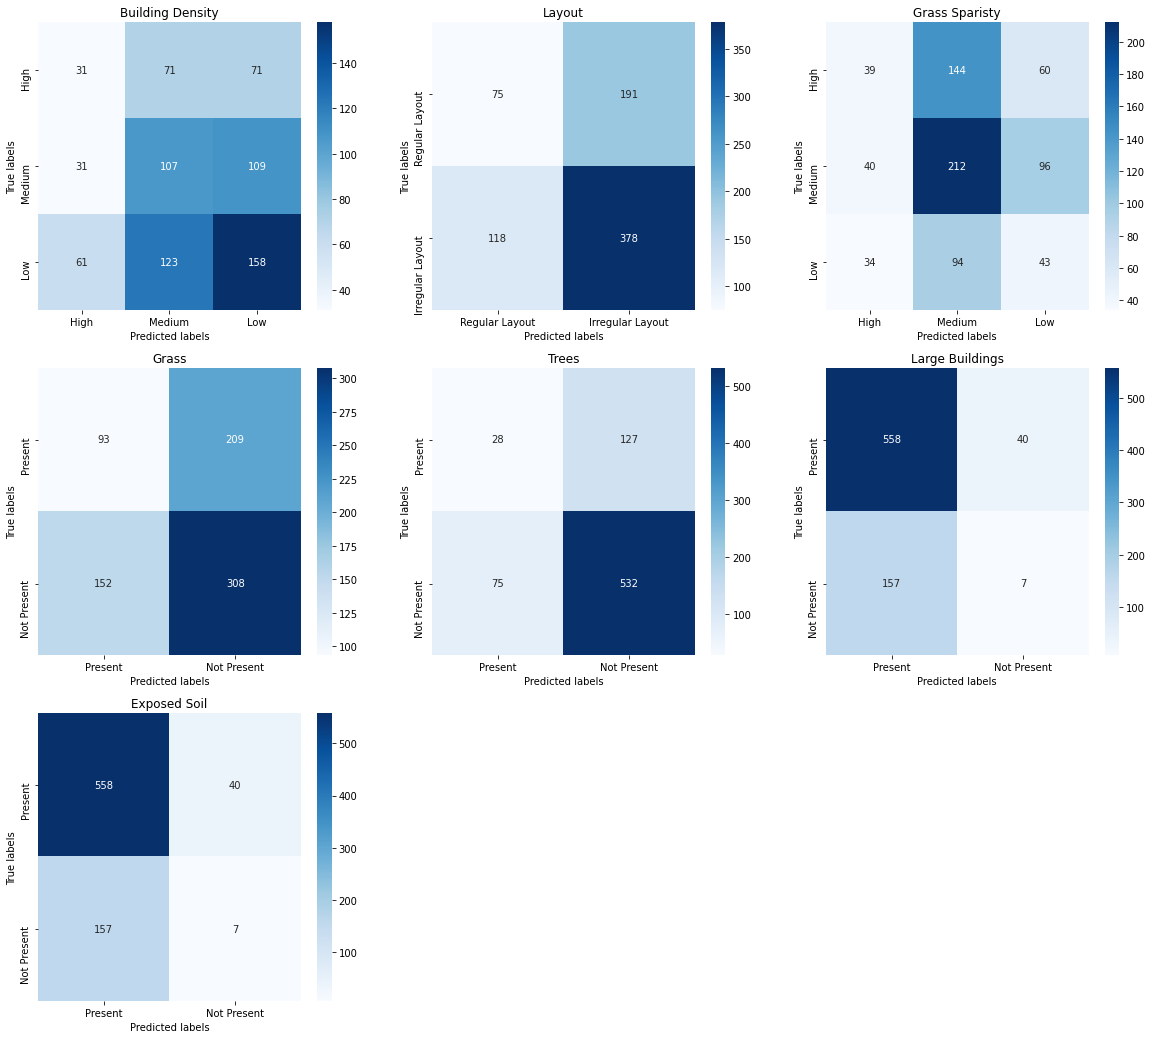

In [ ]:
conf_mat_Task1 = confusion_matrix(true_labels[:,:3].argmax( axis=1), predictions[:,:3].argmax( axis=1)) 
conf_mat_Task2 = confusion_matrix(true_labels[:,3:5].argmax( axis=1), predictions[:,3:5].argmax( axis=1)) 
conf_mat_Task3 = confusion_matrix(true_labels[:,5:8].argmax( axis=1), predictions[:,5:8].argmax( axis=1))   
conf_mat_Task4 = multilabel_confusion_matrix(true_labels[:,8:], predictions[:,8:]) 
  
plt.figure(figsize=(20,18))
printConfusion_Matrix(331,conf_mat_Task1 , ["High", "Medium","Low"] , 'Building Density' )
printConfusion_Matrix(332,conf_mat_Task2 , Pattern_df_columns[1:] , 'Layout' )
printConfusion_Matrix(333,conf_mat_Task3 , ["High", "Medium","Low"] , 'Grass Sparisty' )

printConfusion_Matrix(334,conf_mat_Task4[0] , ['Present','Not Present'] ,  Extra_df_columns[1])
printConfusion_Matrix(335,conf_mat_Task4[1] ,  ['Present','Not Present']  , Extra_df_columns[2])
printConfusion_Matrix(336,conf_mat_Task4[2] ,  ['Present','Not Present'] ,    Extra_df_columns[3])
printConfusion_Matrix(337,conf_mat_Task4[2] ,  ['Present','Not Present']  , Extra_df_columns[4])
  
plt.savefig("/content/drive/My Drive/DeepLearning/Project/Hyderabad_patches/ConfusionMatrix.png")

# Multi-Task Model

In [ ]:
#Dividing DataFrame Into Train Val Test
df = shuffle(df_original  ,random_state=2020)
df.reset_index(inplace=True, drop=True)
df_train, df_test = np.split(df,  [int(.85 * len(df))])
 
print("Total Data" , len(df))
print("Train Data:" , len(df_train), "Test Data:" , len(df_test))

Total Data 5078
Train Data: 4316 Test Data: 762


In [ ]:
building_labels_test = np.array(df_test[Building_df_columns[1:]].values.tolist())
Pattern_labels_test = np.array(df_test[Pattern_df_columns[1:]].values.tolist())
Grass_labels_test = np.array(df_test[Grass_df_columns[1:]].values.tolist())
Extra_labels_test = np.array(df_test[Extra_df_columns[1:]].values.tolist())

pickle_dir = '/content/drive/My Drive/DeepLearning/Project/NewStep/'
fileObject = open(pickle_dir+'X_data_test_new2',"rb")
X_data_test = pkl.load(fileObject)
fileObject.close()
X_data_test.shape



(762, 256, 256, 3)

In [ ]:
model=load_model(models_dir+"multitask_model.h5")

In [ ]:
scores =   model.evaluate({'main_input': X_data_test},
            {'Building_output': building_labels_test,
                    'Pattern_output': Pattern_labels_test,
                    'Grass_output': Grass_labels_test,
                    'Extra_output': Extra_labels_test})

762/762 [==============================] - 10s 13ms/step


In [ ]:
print("loss: ",scores[0] ) 
print("Building_output_loss: ",scores[1] ) 
print("Pattern_output_loss: ",scores[2] )  
print("Grass_output_loss: ",scores[3] ) 
print("Extra_output_loss: ",scores[4] ) 
print("Building_output_accuracy: ", scores[5]  ) 
print("Pattern_output_accuracy: ",scores[6]  ) 
print("Grass_output_accuracy: ",scores[7] )  
print("Extra_output_accuracy: ",scores[8] ) 

loss:  2.3302225371984044
Building_output_loss:  0.581108808517456
Pattern_output_loss:  0.5990616679191589
Grass_output_loss:  0.587806224822998
Extra_output_loss:  0.5607627034187317
Building_output_accuracy:  0.7440944910049438
Pattern_output_accuracy:  0.6811023354530334
Grass_output_accuracy:  0.5669291615486145
Extra_output_accuracy:  0.722769021987915


In [ ]:
pred =   model.predict({'main_input': X_data_test})

In [ ]:
b_prediction  = indices_to_one_hot(np.argmax(pred[0], axis=1),3).astype(int)
p_prediction  = indices_to_one_hot(np.argmax(pred[1], axis=1),2).astype(int)
g_prediction  = indices_to_one_hot(np.argmax(pred[2], axis=1), 3).astype(int)
e_predictions = (pred[3] > 0.5).astype(int)

In [ ]:
predictions = np.concatenate((b_prediction,p_prediction,g_prediction,e_predictions) , axis =1)
predicted_df = pd.DataFrame(predictions, columns=y_labels) 
predicted_df[x_label]= df_test[x_label].to_list()
ordered_cols=[x_label]+y_labels
predicted_df=predicted_df[ordered_cols]
true_labels = df_test[y_labels].to_numpy()

In [ ]:
print(classification_report(true_labels, predictions, target_names=y_labels))

                           precision    recall  f1-score   support

    High Building Density       0.81      0.64      0.71       162
Moderate Building Density       0.62      0.70      0.65       247
     Low Building Density       0.83      0.85      0.84       345
           Regular Layout       0.64      0.12      0.20       247
         Irregular Layout       0.67      0.97      0.79       497
           Dense Greenery       0.25      0.26      0.26        84
          Sparse Greenery       0.55      0.88      0.68       349
     Very Sparse Greenery       0.66      0.46      0.54       172
                    Grass       0.65      0.93      0.77       460
                    Trees       0.80      1.00      0.89       607
          Large Buildings       0.00      0.00      0.00       164
             Exposed Soil       0.67      0.92      0.77       494

                micro avg       0.68      0.78      0.72      3828
                macro avg       0.60      0.64      0.59    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Additional positional arguments to set_ticklabels are ignored, and deprecated since Matplotlib 3.1; passing them will raise a TypeError in Matplotlib 3.3.
  if sys.path[0] == '':


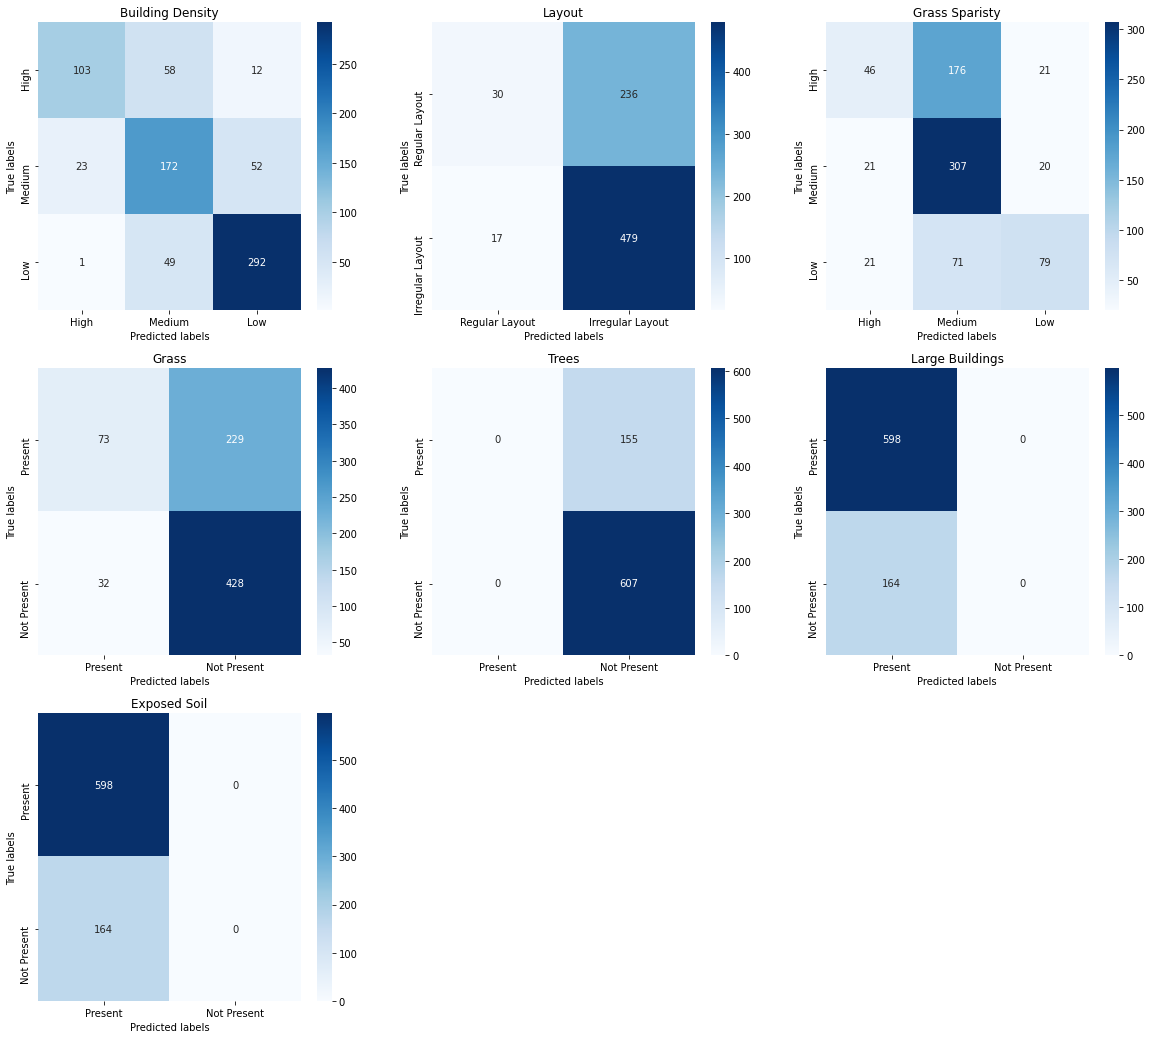

In [ ]:
conf_mat_Task1 = confusion_matrix(true_labels[:,:3].argmax( axis=1), predictions[:,:3].argmax( axis=1)) 
conf_mat_Task2 = confusion_matrix(true_labels[:,3:5].argmax( axis=1), predictions[:,3:5].argmax( axis=1)) 
conf_mat_Task3 = confusion_matrix(true_labels[:,5:8].argmax( axis=1), predictions[:,5:8].argmax( axis=1))   
conf_mat_Task4 = multilabel_confusion_matrix(true_labels[:,8:], predictions[:,8:]) 
  
plt.figure(figsize=(20,18))
printConfusion_Matrix(331,conf_mat_Task1 , ["High", "Medium","Low"] , 'Building Density' )
printConfusion_Matrix(332,conf_mat_Task2 , Pattern_df_columns[1:] , 'Layout' )
printConfusion_Matrix(333,conf_mat_Task3 , ["High", "Medium","Low"] , 'Grass Sparisty' )

printConfusion_Matrix(334,conf_mat_Task4[0] , ['Present','Not Present'] ,  Extra_df_columns[1])
printConfusion_Matrix(335,conf_mat_Task4[1] ,  ['Present','Not Present']  , Extra_df_columns[2])
printConfusion_Matrix(336,conf_mat_Task4[2] ,  ['Present','Not Present'] ,    Extra_df_columns[3])
printConfusion_Matrix(337,conf_mat_Task4[2] ,  ['Present','Not Present']  , Extra_df_columns[4])
  